In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pySODM.models.base import ODEModel
from covid19_DTM.data.utils import construct_initN
from covid19_DTM.models.TDPF import ramp_fun
from covid19_DTM.models.TDPF import make_seasonality_function
from covid19_DTM.data.sciensano import get_sciensano_COVID19_data
import csv
from csv import DictReader
from matplotlib import font_manager
import string
import os

In [3]:
abs_dir = os.getcwd()
rel_dir = '../../data/PHM/interim/UZG/'
file_name = 'MZG_residence_times.csv'

file_name = 'MZG_baseline.csv'
types_dict = {'APR_MDC_key': str, 'week_number': int, 'day_number':int}
baseline = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1,2,3],dtype=types_dict).squeeze()
baseline = baseline.groupby(['APR_MDC_key','week_number','day_number']).mean()
#hospitalization_baseline = hospitalization_baseline.ewm(7).mean()

file_name = 'MZG_2016_2021.csv'
types_dict = {'APR_MDC_key': str}
hospitalizations = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1,2,3],dtype=types_dict).squeeze()
hospitalizations = hospitalizations.groupby(['APR_MDC_key','date']).sum()
hospitalizations.index = hospitalizations.index.set_levels([hospitalizations.index.levels[0], pd.to_datetime(hospitalizations.index.levels[1])])
#hospitalization_baseline = hospitalization_baseline.ewm(7).mean()

file_name = '2020_2021_normalized.csv'
types_dict = {'APR_MDC_key': str}
# mean data
hospitalizations_normalized = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict,parse_dates=True)['mean']
MDC_keys = hospitalizations_normalized.index.get_level_values('APR_MDC_key').unique().values
# lower and upper quantiles
hospitalizations_normalized_quantiles = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict,parse_dates=True).loc[(slice(None), slice(None)), ('q0.025','q0.975')]

MDC_dict={}
file_name = 'MDC_dict.csv'
with open(os.path.join(abs_dir,rel_dir,file_name), mode='r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
        MDC_dict.update({row[0]:row[1]})
MDC_dict.update({'covid':'covid'})


In [4]:
abs_dir = os.getcwd()
result_folder = '../../results/PHM/analysis/queuing_model/parameter_influences/'

label_font = font_manager.FontProperties(family='CMU Sans Serif',
                                style='normal', 
                                size=10)
legend_font = font_manager.FontProperties(family='CMU Sans Serif',
                                style='normal', 
                                size=8)

In [14]:
# line cyclers adapted to colourblind people
from cycler import cycler
line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))
marker_cycler = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["none", "none", "none", "none", "none", "none", "none"]) +
                 cycler(marker=["4", "2", "3", "1", "+", "x", "."]))

In [5]:
hospitalizations

APR_MDC_key  date      
00           2015-07-01    0
             2015-07-02    0
             2015-07-03    0
             2015-07-04    0
             2015-07-05    0
                          ..
PP           2021-12-27    0
             2021-12-28    0
             2021-12-29    0
             2021-12-30    0
             2021-12-31    0
Name: n_patients, Length: 66528, dtype: int64

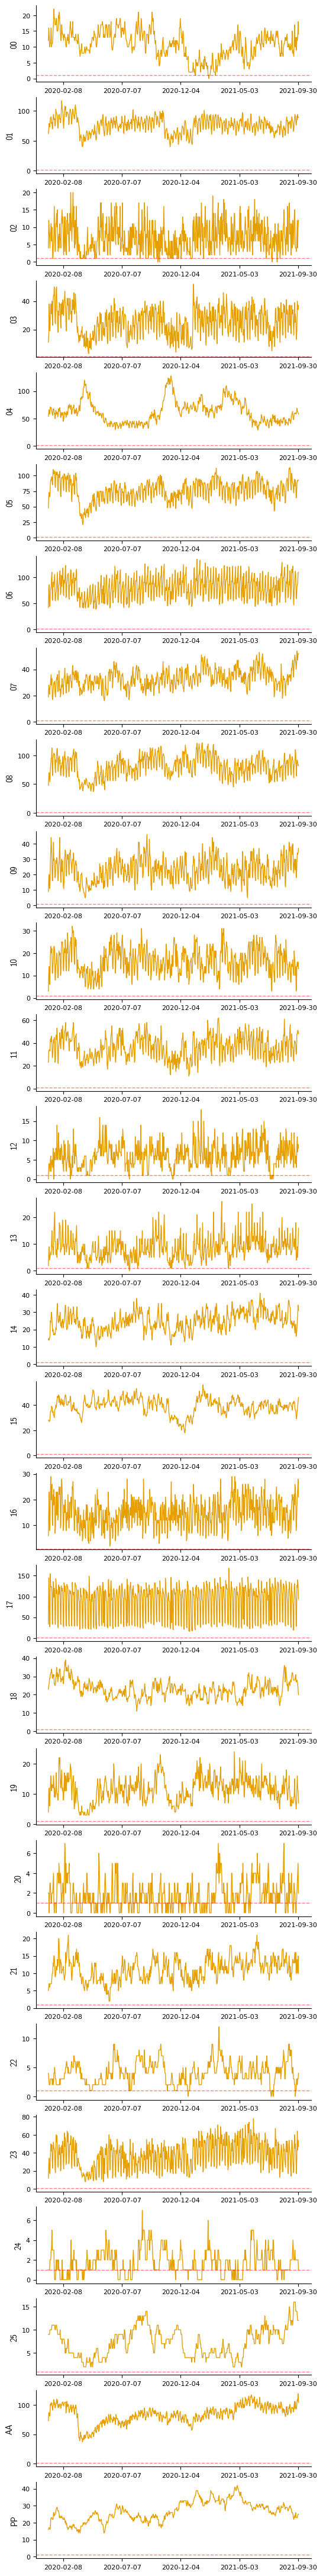

In [17]:
plot_start = pd.to_datetime('2020-01-01')
plot_end = pd.to_datetime('2021-10-01')
plot_time = pd.date_range(plot_start,plot_end)
MDC_plot = MDC_keys

fig,axs = plt.subplots(len(MDC_plot),1,figsize=(6,len(MDC_plot)*2))
for idx,disease in enumerate(MDC_plot):
    #out_plot = pd.DataFrame(out_plot).ewm(7).mean()
    mean = hospitalizations.loc[disease,plot_time]
    #lower = hospitalizations_normalized_quantiles['q0.025'].loc[(disease,plot_time)]
    #upper = hospitalizations_normalized_quantiles['q0.975'].loc[(disease,plot_time)]
    axs[idx].plot(plot_time,mean,linewidth=1,label=MDC_dict[disease])
    #as[idx]x.fill_between(plot_time,lower,upper, color='black',alpha=0.5)
    axs[idx].axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5,linewidth=1)
    #as[idx]x.set_title(disease,font=label_font)
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=8)
    axs[idx].tick_params(axis='both', which='minor', labelsize=8)
    axs[idx].set_ylabel(disease,font=label_font)

#fig.legend(prop=legend_font)
#fig.tight_layout()
fig.savefig('../../results/PHM/analysis/all_hospitalisations.pdf',dpi=600,bbox_inches='tight')

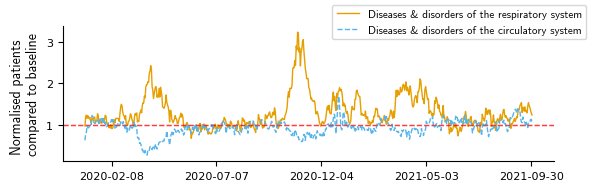

In [15]:
plot_start = pd.to_datetime('2020-01-01')
plot_end = pd.to_datetime('2021-10-01')
plot_time = pd.date_range(plot_start,plot_end)
MDC_plot = ['04','05']

fig,ax=plt.subplots(figsize=(6,2))
ax.set_prop_cycle(line_cycler)
for idx,disease in enumerate(MDC_plot):
    #out_plot = pd.DataFrame(out_plot).ewm(7).mean()
    mean = hospitalizations_normalized.loc[(disease,plot_time)]
    #lower = hospitalizations_normalized_quantiles['q0.025'].loc[(disease,plot_time)]
    #upper = hospitalizations_normalized_quantiles['q0.975'].loc[(disease,plot_time)]
    ax.plot(plot_time,mean,linewidth=1,label=MDC_dict[disease])
    #ax.fill_between(plot_time,lower,upper, color='black',alpha=0.5)
    ax.axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5,linewidth=1)
    #ax.set_title(disease,font=label_font)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_ylabel('Normalised patients \ncompared to baseline',font=label_font)

fig.legend(prop=legend_font)
fig.tight_layout()
fig.savefig('../../results/PHM/analysis/Postponed_healthcare_UZ_Gent',dpi=600,bbox_inches='tight')

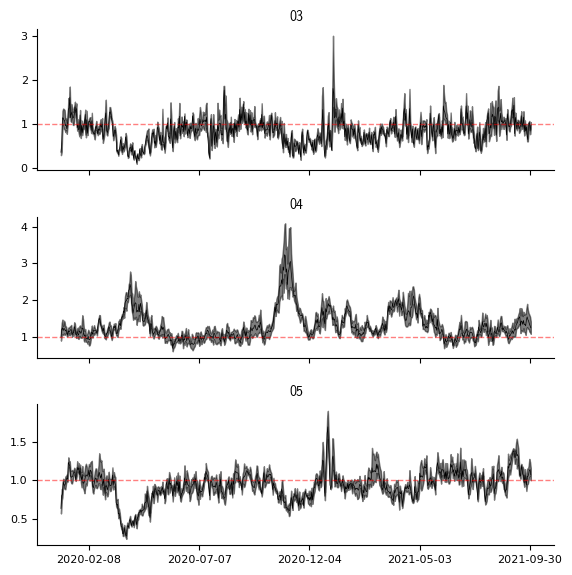

In [32]:
plot_start = pd.to_datetime('2020-01-01')
plot_end = pd.to_datetime('2021-10-01')
plot_time = pd.date_range(plot_start,plot_end)
MDC_plot = ['03','04','05']

fig,axs=plt.subplots(len(MDC_plot),1,figsize=(6,len(MDC_plot)*2),sharex=True)
for idx,disease in enumerate(MDC_plot):
    #out_plot = pd.DataFrame(out_plot).ewm(7).mean()
    mean = hospitalizations_normalized.loc[(disease,plot_time)]
    lower = hospitalizations_normalized_quantiles['q0.025'].loc[(disease,plot_time)]
    upper = hospitalizations_normalized_quantiles['q0.975'].loc[(disease,plot_time)]
    axs[idx].plot(plot_time,mean, label=disease, color='black',linewidth=0.5)
    axs[idx].fill_between(plot_time,lower,upper, color='black',alpha=0.5)
    axs[idx].axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5,linewidth=1)
    axs[idx].set_title(disease,font=label_font)
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=8)
    axs[idx].tick_params(axis='both', which='minor', labelsize=8)

fig.tight_layout()
fig.savefig('../../results/PHM/analysis/UZG_normalized',dpi=600,bbox_inches='tight')

In [110]:
start_date = pd.to_datetime('2020-08-01')
end_date = pd.to_datetime('2021-03-01')
time = pd.date_range(start_date,end_date)
MDC = ['05']

sigmas_dict = {}
data=hospitalizations.loc[(MDC,time)]

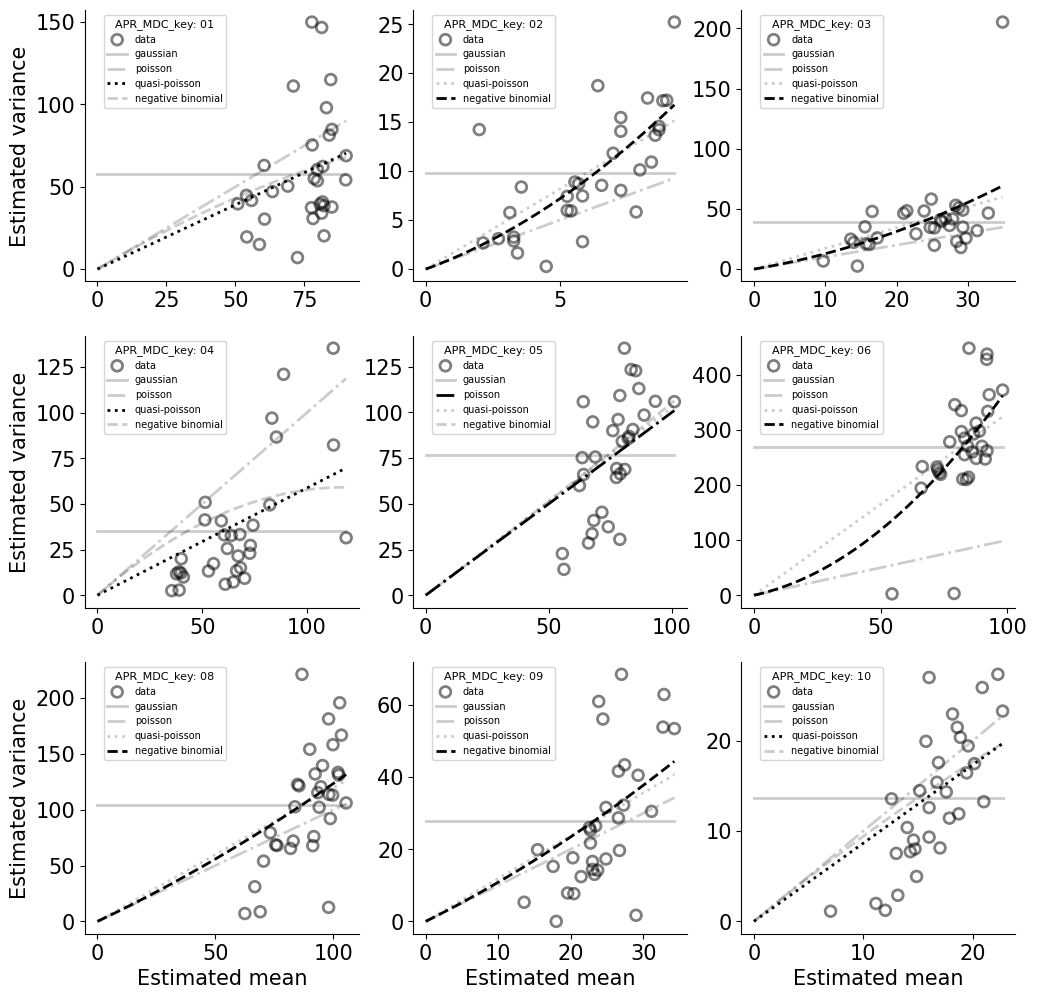

In [125]:
from pySODM.optimization.utils import add_poisson_noise, assign_theta, variance_analysis

start_date = pd.to_datetime('2020-08-01')
end_date = pd.to_datetime('2021-03-01')
time = pd.date_range(start_date,end_date)
MDC = ['01','02','03','04','05','06','08','09','10']

data = hospitalizations.reorder_levels(['date','APR_MDC_key'])
data=data.sort_index()
data=data.loc[(time,MDC)]

sigmas_dict = {}
results, ax = variance_analysis(data, resample_frequency='W')
for MDC_key in MDC:
    sigmas_dict.update({MDC_key:results['theta'].loc[MDC_key,'quasi-poisson']})

In [81]:
def normalize_data(data):
    MDC = data.index.get_level_values('APR_MDC_key').unique()
    time = data.index.get_level_values('date').unique()
    
    multi_index = pd.MultiIndex.from_product([MDC,time])
    baseline_in_date_form = pd.Series(index=multi_index)
    for idx,(disease,date) in enumerate(multi_index):
        baseline_in_date_form[idx] = baseline.loc[(disease,date.isocalendar().week,date.isocalendar().weekday)]

    res = data.copy()
    for disease in np.delete(MDC,MDC=='covid'):
            res[disease]=data[disease]/baseline_in_date_form.loc[disease]
    
    return res

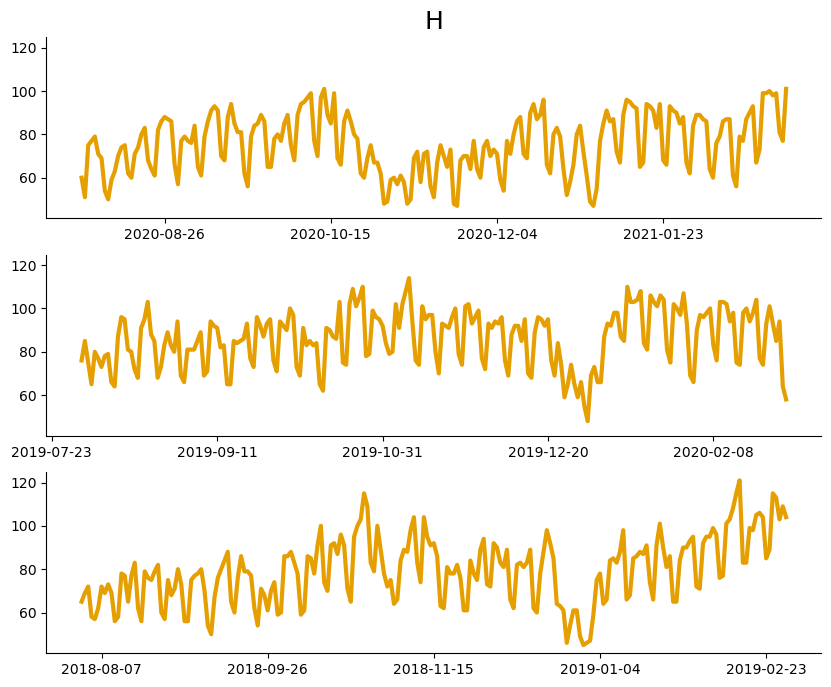

In [102]:
fix,axs=plt.subplots(3,1,figsize=(10,8),sharey=True)

plot_start = pd.to_datetime('2020-08-01')
plot_end = pd.to_datetime('2021-03-01')
plot_time = pd.date_range(plot_start,plot_end)
MDC_plot = ['05']

hospitalizations_plot = hospitalizations.loc[(slice(None),plot_time)]
for disease in MDC_plot:
    #out_plot = pd.DataFrame(out_plot).ewm(7).mean()
    axs[0].plot(plot_time,hospitalizations_plot[disease], label=disease)
    axs[0].set_title('H')
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[0].grid(False)
    axs[0].tick_params(axis='both', which='major', labelsize=10)
    axs[0].tick_params(axis='both', which='minor', labelsize=8)

plot_start = pd.to_datetime('2019-08-01')
plot_end = pd.to_datetime('2020-03-01')
plot_time = pd.date_range(plot_start,plot_end)
MDC_plot = ['05']

hospitalizations_plot = hospitalizations.loc[(slice(None),plot_time)]
for disease in MDC_plot:
    #out_plot = pd.DataFrame(out_plot).ewm(7).mean()
    axs[1].plot(plot_time,hospitalizations_plot[disease], label=disease)
    axs[1].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[1].grid(False)
    axs[1].tick_params(axis='both', which='major', labelsize=10)
    axs[1].tick_params(axis='both', which='minor', labelsize=8)

plot_start = pd.to_datetime('2018-08-01')
plot_end = pd.to_datetime('2019-03-01')
plot_time = pd.date_range(plot_start,plot_end)
MDC_plot = ['05']

hospitalizations_plot = hospitalizations.loc[(slice(None),plot_time)]
for disease in MDC_plot:
    #out_plot = pd.DataFrame(out_plot).ewm(7).mean()
    axs[2].plot(plot_time,hospitalizations_plot[disease], label=disease)
    axs[2].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[2].grid(False)
    axs[2].tick_params(axis='both', which='major', labelsize=10)
    axs[2].tick_params(axis='both', which='minor', labelsize=8)

plt.show()

C:\Users\wolfd\AppData\Local\Temp\ipykernel_14764\980747272.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  baseline_in_date_form = pd.Series(index=multi_index)
C:\Users\wolfd\AppData\Local\Temp\ipykernel_14764\980747272.py:28: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  baseline_in_date_form = pd.Series(index=multi_index)
C:\Users\wolfd\AppData\Local\Temp\ipykernel_14764\980747272.py:46: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  baseline_in_date_form = pd.Series(index=multi_index)


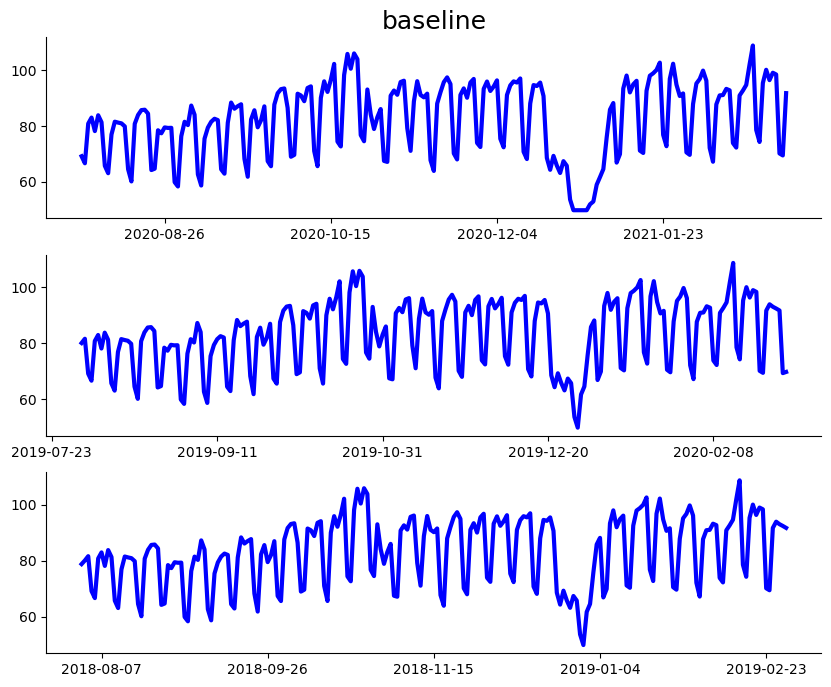

In [103]:
fix,axs=plt.subplots(3,1,figsize=(10,8),sharey=True)

plot_start = pd.to_datetime('2020-08-01')
plot_end = pd.to_datetime('2021-03-01')
plot_time = pd.date_range(plot_start,plot_end)
MDC_plot = ['05']

multi_index = pd.MultiIndex.from_product([MDC_plot,plot_time])
baseline_in_date_form = pd.Series(index=multi_index)
for idx,(disease,date) in enumerate(multi_index):
    baseline_in_date_form[idx] = baseline.loc[(disease,date.isocalendar().week,date.isocalendar().weekday)]

for disease in MDC_plot:
    #out_plot = pd.DataFrame(out_plot).ewm(7).mean()
    axs[0].plot(plot_time,baseline_in_date_form[disease], label=disease,color='blue')
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[0].grid(False)
    axs[0].set_title('baseline')
    axs[0].tick_params(axis='both', which='major', labelsize=10)
    axs[0].tick_params(axis='both', which='minor', labelsize=8)

plot_start = pd.to_datetime('2019-08-01')
plot_end = pd.to_datetime('2020-03-01')
plot_time = pd.date_range(plot_start,plot_end)
MDC_plot = ['05']

multi_index = pd.MultiIndex.from_product([MDC_plot,plot_time])
baseline_in_date_form = pd.Series(index=multi_index)
for idx,(disease,date) in enumerate(multi_index):
    baseline_in_date_form[idx] = baseline.loc[(disease,date.isocalendar().week,date.isocalendar().weekday)]
    
for disease in MDC_plot:
    #out_plot = pd.DataFrame(out_plot).ewm(7).mean()
    axs[1].plot(plot_time,baseline_in_date_form[disease], label=disease,color='blue')
    axs[1].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[1].grid(False)
    axs[1].tick_params(axis='both', which='major', labelsize=10)
    axs[1].tick_params(axis='both', which='minor', labelsize=8)

plot_start = pd.to_datetime('2018-08-01')
plot_end = pd.to_datetime('2019-03-01')
plot_time = pd.date_range(plot_start,plot_end)
MDC_plot = ['05']

multi_index = pd.MultiIndex.from_product([MDC_plot,plot_time])
baseline_in_date_form = pd.Series(index=multi_index)
for idx,(disease,date) in enumerate(multi_index):
    baseline_in_date_form[idx] = baseline.loc[(disease,date.isocalendar().week,date.isocalendar().weekday)]
    
for disease in MDC_plot:
    #out_plot = pd.DataFrame(out_plot).ewm(7).mean()
    axs[2].plot(plot_time,baseline_in_date_form[disease], label=disease,color='blue')
    axs[2].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[2].grid(False)
    axs[2].tick_params(axis='both', which='major', labelsize=10)
    axs[2].tick_params(axis='both', which='minor', labelsize=8)

plt.show()

C:\Users\wolfd\AppData\Local\Temp\ipykernel_14764\2261615752.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  baseline_in_date_form = pd.Series(index=multi_index)


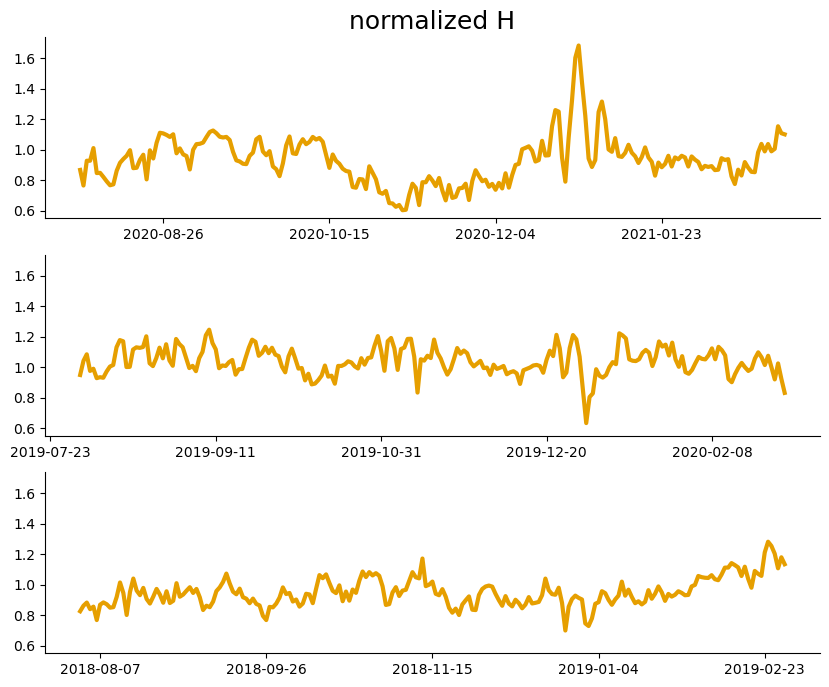

In [104]:
fix,axs=plt.subplots(3,1,figsize=(10,8),sharey=True)

plot_start = pd.to_datetime('2020-08-01')
plot_end = pd.to_datetime('2021-03-01')
plot_time = pd.date_range(plot_start,plot_end)
MDC_plot = ['05']

hospitalizations_normalised = normalize_data(hospitalizations.loc[(slice(None),plot_time)])
for disease in MDC_plot:
    #out_plot = pd.DataFrame(out_plot).ewm(7).mean()
    axs[0].plot(plot_time,hospitalizations_normalised[disease], label=disease)
    axs[0].set_title('normalized H')
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[0].grid(False)
    axs[0].tick_params(axis='both', which='major', labelsize=10)
    axs[0].tick_params(axis='both', which='minor', labelsize=8)

plot_start = pd.to_datetime('2019-08-01')
plot_end = pd.to_datetime('2020-03-01')
plot_time = pd.date_range(plot_start,plot_end)
MDC_plot = ['05']

hospitalizations_normalised = normalize_data(hospitalizations.loc[(slice(None),plot_time)])
for disease in MDC_plot:
    #out_plot = pd.DataFrame(out_plot).ewm(7).mean()
    axs[1].plot(plot_time,hospitalizations_normalised[disease], label=disease)
    axs[1].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[1].grid(False)
    axs[1].tick_params(axis='both', which='major', labelsize=10)
    axs[1].tick_params(axis='both', which='minor', labelsize=8)

plot_start = pd.to_datetime('2018-08-01')
plot_end = pd.to_datetime('2019-03-01')
plot_time = pd.date_range(plot_start,plot_end)
MDC_plot = ['05']

hospitalizations_normalised = normalize_data(hospitalizations.loc[(slice(None),plot_time)])
for disease in MDC_plot:
    #out_plot = pd.DataFrame(out_plot).ewm(7).mean()
    axs[2].plot(plot_time,hospitalizations_normalised[disease], label=disease)
    axs[2].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[2].grid(False)
    axs[2].tick_params(axis='both', which='major', labelsize=10)
    axs[2].tick_params(axis='both', which='minor', labelsize=8)

plt.show()